<a href="https://colab.research.google.com/github/chihyanghsu0805/machine_learning/blob/tutorials/tutorials/keras/graph_attention_network/node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook re-implements the tutorial on https://keras.io/examples/graph/gat_node_classification/.

# Load Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(42)

# Get Dataset

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

# Exploratory Data Analysis

In [3]:
# Rows are papers, columns are paper_id, features, subject. 
print(papers)

      paper_id  term_0  term_1  ...  term_1431  term_1432  \
0        31336       0       0  ...          0          0   
1      1061127       0       0  ...          0          0   
2      1106406       0       0  ...          0          0   
...        ...     ...     ...  ...        ...        ...   
2705   1128978       0       0  ...          0          0   
2706    117328       0       0  ...          0          0   
2707     24043       0       0  ...          0          0   

                     subject  
0            Neural_Networks  
1              Rule_Learning  
2     Reinforcement_Learning  
...                      ...  
2705      Genetic_Algorithms  
2706              Case_Based  
2707         Neural_Networks  

[2708 rows x 1435 columns]


In [4]:
# Edges / Citations
print(citations)

      target   source
0         35     1033
1         35   103482
2         35   103515
...      ...      ...
5426  853118  1140289
5427  853155   853118
5428  954315  1155073

[5429 rows x 2 columns]


In [5]:
class_values = sorted(papers["subject"].unique())
print(class_values)

['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']


<BarContainer object of 7 artists>

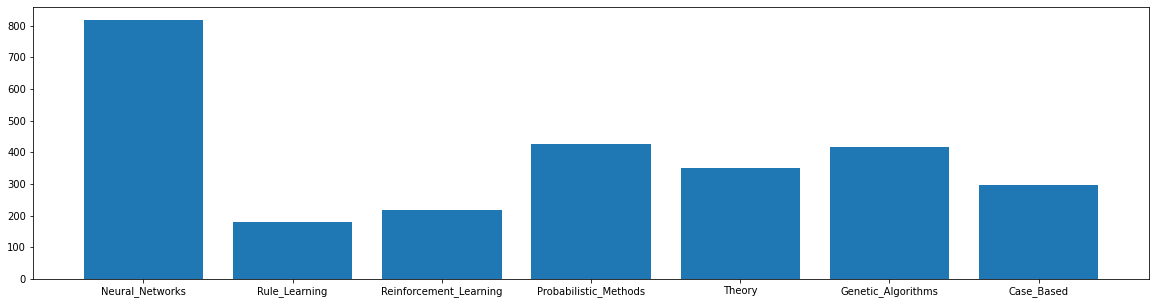

In [6]:
class_counts = collections.Counter(papers["subject"])
plt.figure(figsize=(20, 5))
plt.bar(class_counts.keys(), class_counts.values())

In [7]:
# Map entries to index
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {
    name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))
}

print(class_idx)
print(paper_idx)

{'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6}
{35: 0, 40: 1, 114: 2, 117: 3, 128: 4, 130: 5, 164: 6, 288: 7, 424: 8, 434: 9, 463: 10, 504: 11, 506: 12, 887: 13, 906: 14, 910: 15, 936: 16, 940: 17, 941: 18, 943: 19, 1026: 20, 1033: 21, 1034: 22, 1035: 23, 1213: 24, 1237: 25, 1246: 26, 1272: 27, 1365: 28, 1385: 29, 1481: 30, 1688: 31, 1694: 32, 1717: 33, 1786: 34, 1817: 35, 1919: 36, 1949: 37, 1951: 38, 1952: 39, 1953: 40, 1955: 41, 1956: 42, 1959: 43, 1997: 44, 1999: 45, 2354: 46, 2440: 47, 2653: 48, 2654: 49, 2658: 50, 2663: 51, 2665: 52, 2695: 53, 2696: 54, 2698: 55, 2702: 56, 3084: 57, 3085: 58, 3095: 59, 3097: 60, 3101: 61, 3112: 62, 3187: 63, 3191: 64, 3192: 65, 3217: 66, 3218: 67, 3220: 68, 3222: 69, 3223: 70, 3229: 71, 3231: 72, 3232: 73, 3233: 74, 3235: 75, 3236: 76, 3237: 77, 3240: 78, 3243: 79, 3828: 80, 3932: 81, 4274: 82, 4329: 83, 4330: 84, 4335: 85, 4553: 86, 4584: 

In [8]:
# Write mappings back
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])


In [9]:
print(papers)
print(citations)

      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
0          462       0       0  ...          0          0        2
1         1911       0       0  ...          0          0        5
2         2002       0       0  ...          0          0        4
...        ...     ...     ...  ...        ...        ...      ...
2705      2372       0       0  ...          0          0        1
2706       955       0       0  ...          0          0        0
2707       376       0       0  ...          0          0        2

[2708 rows x 1435 columns]
      target  source
0          0      21
1          0     905
2          0     906
...      ...     ...
5426    1874    2586
5427    1876    1874
5428    1897    2707

[5429 rows x 2 columns]


# Data Preparation

In [10]:
# Obtain random indices
random_indices = np.random.permutation(range(papers.shape[0]))

# 50/50 split
train_ratio = 0.5
train_idx = int(len(random_indices) * train_ratio)
train_data = papers.iloc[random_indices[:train_idx]]
test_data = papers.iloc[random_indices[train_idx:]]

In [11]:
print(train_data)
print(test_data)

      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
1044      2279       0       0  ...          0          0        2
439        795       0       0  ...          0          0        2
1729      1054       0       0  ...          0          0        1
...        ...     ...     ...  ...        ...        ...      ...
2291       615       0       0  ...          0          0        5
338       2356       0       0  ...          0          0        2
1706       909       0       0  ...          0          0        0

[1354 rows x 1435 columns]
      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
2252      1491       0       0  ...          0          0        1
2271      2288       0       0  ...          0          0        1
1501      2269       0       0  ...          0          0        2
...        ...     ...     ...  ...        ...        ...      ...
1130      1255       0       0  ...          0          0        1
1294      1381       0       0  ..

In [12]:
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

# Define graph, namely an edge tensor and a node feature tensor
feature_start = 1
feature_end = -1
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(
    papers.sort_values("paper_id").iloc[:, feature_start:feature_end]
  )

In [13]:
print(f"Edges shape: {edges.shape}")
print(f"Node features shape: {node_states.shape}")

Edges shape: (5429, 2)
Node features shape: (2708, 1433)


# Building the model

GAT takes as input a graph (namely an edge tensor and a node feature tensor) and
outputs \[updated\] node states. The node states are, for each target node, neighborhood
aggregated information of *N*-hops (where *N* is decided by the number of layers of the
GAT). Importantly, in contrast to the
[graph convolutional network](https://arxiv.org/abs/1609.02907) (GCN)
the GAT makes use of attention machanisms
to aggregate information from neighboring nodes (or *source nodes*). In other words, instead of simply
averaging/summing node states from source nodes (*source papers*) to the target node (*target papers*),
GAT first applies normalized attention scores to each source node state and then sums.

### (Multi-head) graph attention layer

The GAT model implements multi-head graph attention layers. The `MultiHeadGraphAttention` layer is simply a concatenation (or averaging) of multiple graph attention layers (`GraphAttention`), each with separate learnable weights `W`. The `GraphAttention` layer does the following:

1. Linear transfrom input node states with W to give Z.
```
node_states_transformed = tf.matmul(node_states, self.kernel)
```
2. Computes pair-wise attention scores.
```
node_states_expanded = tf.gather(node_states_transformed, edges)
node_states_expanded = tf.reshape(node_states_expanded, (tf.shape(edges)[0], -1))
attention_scores = tf.nn.leaky_relu(tf.matmul(node_states_expanded, self.kernel_attention))
attention_scores = tf.squeeze(attention_scores, -1)
```

2. Normalizes attention scores.
```
attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
attention_scores_sum = tf.math.unsorted_segment_sum(
      data=attention_scores,
      segment_ids=edges[:, 0], # Incoming nodes
      num_segments=tf.reduce_max(edges[:, 0]) + 1 # node index start with 0
)
attention_scores_sum = tf.repeat(attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32")))
attention_scores_norm = attention_scores / attention_scores_sum
```
4. Applies attention scores  and adds it to the new target node state.
```
node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
out = tf.math.unsorted_segment_sum(
        data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
        segment_ids=edges[:, 0], # Incoming nodes
        num_segments=tf.shape(node_states)[0],
)
```

https://www.tensorflow.org/api_docs/python/tf/gather

https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum


In [14]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):

        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linear Transform
        node_states_transformed = tf.matmul(node_states, self.kernel)

        # Compute pair-wise attention scores
        node_states_expanded = tf.gather(node_states_transformed, edges)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)

        # Normalize attention scores
        attention_scores = tf.math.exp(
            tf.clip_by_value(attention_scores, -2, 2)
        )
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum,
            tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out

In [15]:
class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]

        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        
        # Activate and return node states
        return tf.nn.relu(outputs)

Note that the GAT model operates on the entire graph in all phases (training, validation and testing).

The difference between the phases are the indices (and labels), which gathers certain outputs (`tf.gather(outputs, indices)`).

In [16]:
class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):

        indices, labels = data
        with tf.GradientTape() as tape:
            
            outputs = self([self.node_states, self.edges])            
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        
        grads = tape.gradient(loss, self.trainable_weights)        
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        
        indices = data        
        outputs = self([self.node_states, self.edges])
        
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        
        indices, labels = data
        
        outputs = self([self.node_states, self.edges])        
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}


# Train and Evaluate

In [17]:
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9

In [18]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

# Build model
gat_model = GraphAttentionNetwork(
    node_states, edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
)

# Compile model
gat_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

gat_model.fit(
    x=train_indices,
    y=train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping],
    verbose=2,
)

_, test_accuracy = gat_model.evaluate(x=test_indices, y=test_labels, verbose=0)

print(f"\nTest Accuracy {test_accuracy*100:.1f}%")

Epoch 1/100
5/5 - 48s - loss: 1.8955 - acc: 0.2578 - val_loss: 1.6743 - val_acc: 0.3824 - 48s/epoch - 10s/step
Epoch 2/100
5/5 - 6s - loss: 1.3302 - acc: 0.5353 - val_loss: 1.2094 - val_acc: 0.5735 - 6s/epoch - 1s/step
Epoch 3/100
5/5 - 6s - loss: 0.7828 - acc: 0.7479 - val_loss: 0.9264 - val_acc: 0.6471 - 6s/epoch - 1s/step
Epoch 4/100
5/5 - 6s - loss: 0.4905 - acc: 0.8612 - val_loss: 0.7895 - val_acc: 0.7574 - 6s/epoch - 1s/step
Epoch 5/100
5/5 - 6s - loss: 0.2911 - acc: 0.9163 - val_loss: 0.7960 - val_acc: 0.7500 - 6s/epoch - 1s/step
Epoch 6/100
5/5 - 6s - loss: 0.1793 - acc: 0.9516 - val_loss: 0.8073 - val_acc: 0.7500 - 6s/epoch - 1s/step
Epoch 7/100
5/5 - 6s - loss: 0.1127 - acc: 0.9795 - val_loss: 0.9259 - val_acc: 0.7279 - 6s/epoch - 1s/step
Epoch 8/100
5/5 - 6s - loss: 0.0746 - acc: 0.9885 - val_loss: 0.7807 - val_acc: 0.7794 - 6s/epoch - 1s/step
Epoch 9/100
5/5 - 6s - loss: 0.0472 - acc: 0.9951 - val_loss: 0.8624 - val_acc: 0.7647 - 6s/epoch - 1s/step
Epoch 10/100
5/5 - 6s - l

In [19]:
test_probs = gat_model.predict(x=test_indices)
pred_labels = [np.argmax(x) for x in test_probs]

In [20]:
def plot_confusion_matrix(cm, target_names, title="Confusion Matrix", cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(
                "%7.2f" % (cm[x][y] * 100),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center"
            )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

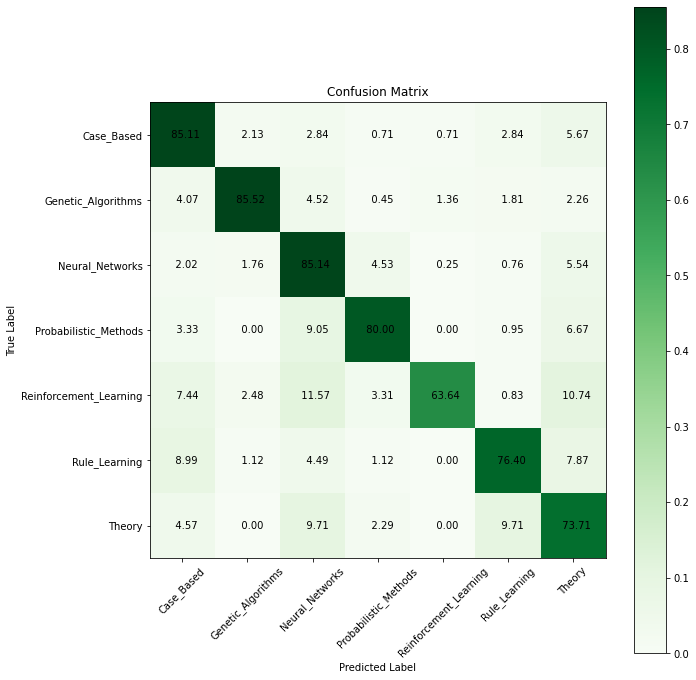

In [21]:
results = confusion_matrix(test_labels, pred_labels, normalize="true")   
plt.figure(figsize=(10, 10))
plot_confusion_matrix(results, class_values)